In [1]:
import cv2 
import torch 
from enum import Enum 
import os 
import numpy as np 
import time


class ModelType(Enum): 
    DPT_LARGE = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
    DPT_Hybrid = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
    MIDAS_SMALL = "MiDaS_small" # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

def draw_grid(image):
    HEIGHT,WIDTH,CHANNELS = image.shape
    one_third_height = HEIGHT//3
    one_third_width = WIDTH//3
    new_image = np.copy(image)
    cv2.line(new_image,(one_third_width,0),(one_third_width,HEIGHT),(0,0,0),5)
    cv2.line(new_image,(2*one_third_width,0),(2*one_third_width,HEIGHT),(0,0,0),5)
    cv2.line(new_image,(0,one_third_height),(WIDTH,one_third_height),(0,0,0),5)
    cv2.line(new_image,(0,2*one_third_height),(WIDTH,2*one_third_height),(0,0,0),5)
    return new_image
    
def vibration_matrix(mask):
    HEIGHT,WIDTH = mask.shape
    one_third_height = HEIGHT//3
    one_third_width = WIDTH//3
    
    COUNT_THRESH = (one_third_height*one_third_width)/5 #10%
    freq_matrix = np.zeros((3,3))
    
    output = np.zeros((HEIGHT,WIDTH,3))
    
    for i in range(3):
        for j in range(3):
            startx = one_third_width*i
            endx = startx + one_third_width
            starty = one_third_height*j
            endy = starty + one_third_height
            
            box = mask[starty:endy,startx:endx]
            
            freq_matrix[i][j] = np.sum(box==1)
            
            clr = (0,255,0) if freq_matrix[i][j]<COUNT_THRESH else (255,0,0)
            cv2.rectangle(output,(startx,starty),(endx,endy),clr,thickness = cv2.FILLED)

    output = draw_grid(output)
    # for row in freq_matrix:
    #     print(row)
    
    return output

            
    
    # print(freq_matrix)
    
    # binary_matrix = freq_matrix > COUNT_THRESH
    
            
            
    
       
class Midas(): 
    def __init__(self,modelType:ModelType=ModelType.DPT_LARGE): 
        self.midas = torch.hub.load("isl-org/MiDaS", modelType.value)
        self.modelType = modelType
        self.THRESH = 0

    def useCUDA(self):
        print(torch.cuda.is_available())
        if torch.cuda.is_available():
            print('Using CUDA')
            self.device = torch.device("cuda") 
        else: 
            print('Using CPU')
            self.device = torch.device("cpu")
        self.midas.to(self.device)
        self.midas.eval()

    def transform(self): 
        print('Transform')
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        if self.modelType.value == "DPT_Large":
            self.transform = midas_transforms.dpt_transform
            self.THRESH = 26
        elif self.modelType.value == "DPT_Hybrid":
            self.transform = midas_transforms.dpt_transform
            self.THRESH = 1900
        else:
            self.transform = midas_transforms.small_transform
            self.THRESH = 850
    
    def predict(self,frame): 
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = self.transform(img).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depthMap = prediction.cpu().numpy()
        # depthMap = cv2.normalize(depthMap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        # depthMap = cv2.applyColorMap(depthMap, cv2.COLORMAP_INFERNO)
        return depthMap
    
    def livePredict(self): 
        print('Starting webcam (press q to quit)...')
        capObj = cv2.VideoCapture(0)
        while True: 
            ret,frame = capObj.read()
            t1 = time.time()
            depthMap = self.predict(frame)
            t2 = time.time()
            # print(int((t2-t1)*1000))
            #depthMap = cv2.cvtColor(depthMap, cv2.COLOR_BGR2GRAY)
            img = frame
            mask = depthMap > self.THRESH
            
            img[mask]=[255,0,0] 
            img = draw_grid(img)
            output = vibration_matrix(mask)
            
            depthMap = cv2.normalize(depthMap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            depthMap_rgb = cv2.applyColorMap(depthMap, cv2.COLORMAP_INFERNO)
            
            combined = cv2.hconcat([depthMap_rgb, img])
            cv2.imshow('Combined',combined)
            cv2.imshow('output',output)
            # cv2.imshow('gray',depthMap)
            # cv2.imshow('mask',(mask*255).astype(np.uint8))
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        capObj.release()
        cv2.destroyAllWindows()
        
def run(modelType:ModelType):
    midasObj = Midas(modelType)
    midasObj.useCUDA() 
    midasObj.transform() 
    midasObj.livePredict() 

def run_on_image(modelType:ModelType):
    midasObj = Midas(modelType)
    midasObj.useCUDA() 
    midasObj.transform() 
    midasObj.livePredict() 



In [2]:
modelType= ModelType.DPT_LARGE
midasObj = Midas(modelType)
midasObj.useCUDA() 
midasObj.transform() 

Using cache found in /home/bhavesh/.cache/torch/hub/isl-org_MiDaS_master
/home/bhavesh/.pyenv/versions/3.9.16/envs/pathpal_vm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bhavesh/.pyenv/versions/3.9.16/envs/pathpal_vm/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


True
Using CUDA
Transform


Using cache found in /home/bhavesh/.cache/torch/hub/intel-isl_MiDaS_master


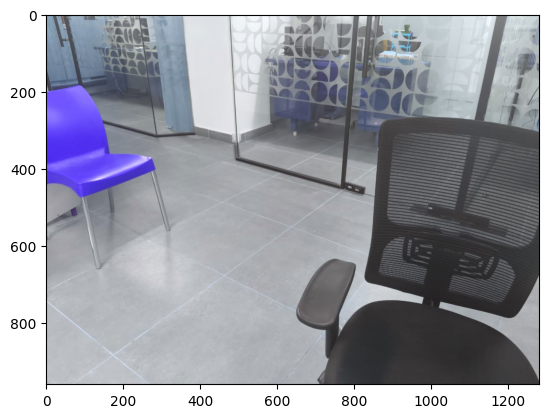

In [3]:
import matplotlib.pyplot as plt

image_path = r"/home/bhavesh/pathpal/depthmap/test_image2.jpg"
image = cv2.imread(image_path)
# print(image)
plt.imshow(image)

(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

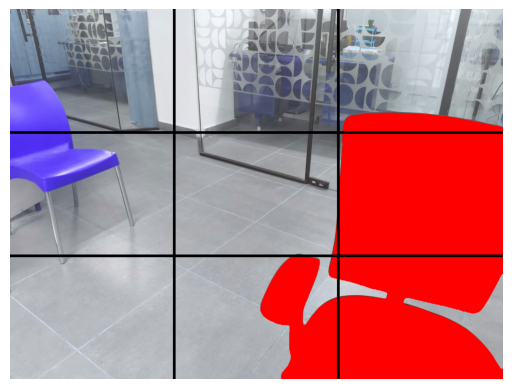

In [4]:

depthMap = midasObj.predict(image)
# print(int((t2-t1)*1000))
#depthMap = cv2.cvtColor(depthMap, cv2.COLOR_BGR2GRAY)
mask = depthMap > midasObj.THRESH

image[mask]=[255,0,0] 
image1 = draw_grid(image)
output = vibration_matrix(mask)

depthMap = cv2.normalize(depthMap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
depthMap_rgb = cv2.applyColorMap(depthMap, cv2.COLORMAP_INFERNO)

combined = cv2.hconcat([depthMap_rgb, image])
plt.imshow(image1)
plt.axis('off')
# plt.imshow(output)
# cv2.imshow('Combined',combined)
# cv2.imshow('output',output)
# cv2.imshow('gray',depthMap)
# cv2.imshow('mask',(mask*255).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

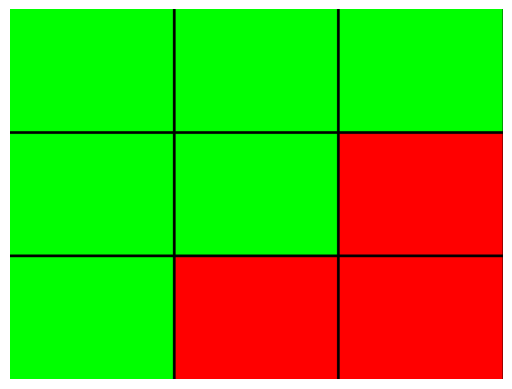

In [5]:
# # print(output.shape)
# output1 = (output * 255).astype('uint8')
# plt.imshow(output1)
plt.imshow(output)
plt.axis('off')